<a href="https://colab.research.google.com/github/mlFanatic/Epilepsy-Detection/blob/master/First_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [221]:
!git clone https://github.com/mlFanatic/Epilepsy-Detection.git

fatal: destination path 'Epilepsy-Detection' already exists and is not an empty directory.


In [149]:
!pip install pyedflib

In [150]:
!pip install wfdb

In [0]:
from pyedflib import highlevel
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import pandas as pd
from pathlib import Path
import os
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [0]:
pwd

'/content'

In [0]:
cd Epilepsy-Detection/

/content/Epilepsy-Detection


In [0]:
path = Path("/content/Epilepsy-Detection/Dataset/")

In [0]:
seizures = list(path.rglob('*.edf'))
anno = list(path.rglob('*.seizures'))

In [0]:
assert seizures is not None
assert anno is not None

In [155]:
total_preictal = []
total_seizures = []
total_postictal = []
for seizure, annot in zip(seizures, anno):
    print(seizure,'\t')
    print(annot,'\n')
    signals, signal_headers, header = highlevel.read_edf(str(seizure))
    ann = wfdb.rdann(str(seizure),"seizures")
    pre_ictal = []
    seizuress = []
    post_ictal = []
    for signal in signals:
        pre_ictal.append(signal[1: ann.sample[0]])
        seizuress.append(signal[ann.sample[0]: ann.sample[1]])
        post_ictal.append(signal[ann.sample[1]: -1])
    total_preictal.append(pre_ictal)
    total_seizures.append(seizuress)
    total_postictal.append(post_ictal)
np.shape(total_seizures)

/content/Epilepsy-Detection/Dataset/chb01/chb01_18.edf 	
/content/Epilepsy-Detection/Dataset/chb01/chb01_03.edf.seizures 

/content/Epilepsy-Detection/Dataset/chb01/chb01_26.edf 	
/content/Epilepsy-Detection/Dataset/chb01/chb01_21.edf.seizures 

/content/Epilepsy-Detection/Dataset/chb01/chb01_16.edf 	
/content/Epilepsy-Detection/Dataset/chb01/chb01_04.edf.seizures 

/content/Epilepsy-Detection/Dataset/chb01/chb01_03.edf 	
/content/Epilepsy-Detection/Dataset/chb01/chb01_26.edf.seizures 

/content/Epilepsy-Detection/Dataset/chb01/chb01_04.edf 	
/content/Epilepsy-Detection/Dataset/chb01/chb01_16.edf.seizures 

/content/Epilepsy-Detection/Dataset/chb01/chb01_15.edf 	
/content/Epilepsy-Detection/Dataset/chb01/chb01_18.edf.seizures 

/content/Epilepsy-Detection/Dataset/chb01/chb01_21.edf 	
/content/Epilepsy-Detection/Dataset/chb01/chb01_15.edf.seizures 

/content/Epilepsy-Detection/Dataset/chb02/chb02_16+.edf 	
/content/Epilepsy-Detection/Dataset/chb02/chb02_16+.edf.seizures 

/content/Epile

(10, 23)

In [156]:
train = []
labels = []
for i in range(np.shape(total_preictal)[0]):
    for j in range (int(np.shape(total_preictal[i])[1] / 100)):
        temp = []
        for k in range(np.shape(total_preictal)[1]):
            temp.append(total_preictal[i][k][j:j+100])
        train.append(temp)
        labels.append(0)
        temp.clear()
        for k in range(np.shape(total_preictal)[1]):
            temp.append(total_seizures[i][k][j:j+100])
        train.append(temp)
        labels.append(1)
        temp.clear()
        for k in range(np.shape(total_preictal)[1]):
            temp.append(total_postictal[i][k][j:j+100])
        train.append(temp)
        labels.append(2)
np.shape(train), np.shape(labels)

((135075, 23, 100), (135075,))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.33, random_state=42)

In [176]:
# One change that we can do is instead of dividing the dataset after concatenating preictal, seizure and postictal, 
# we can do the split separately and then concatenate
np.shape((X_train)), torch.tensor(y_train)[20000], np.shape(X_test), np.shape(y_test), torch.tensor([1,2,3,5,4]).shape

((90500, 23, 100), tensor(1), (44575, 23, 100), (44575,), torch.Size([5]))

In [0]:
class epilepsy_dataset(Dataset):
  def __init__(self, train, classes, transform=None):
    self.data = train
    self.labels = classes
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      print("test torch.istensor in epilepsy_dataset")
      idx = idx.tolist()
    
    sample = {'signal': self.data[idx], 'label': self.labels[idx]}
    if self.transform:
      sample = self.transform(sample)
    return sample

In [0]:
class ToTensor(object):
  def __call__(self, sample):
        signal, label = sample['signal'], sample['label']

        return {'signal': torch.tensor(signal),
                'label': torch.tensor(label)}

In [0]:
def my_collate(batch):
  
  elem = signal[0]
  data = []
  for key in elem:
    print(type(key), " ", key)
    for d in signal:
      data = d[key]
      print(" signal " , np.shape(data), d['label'])
      elem_type = type(data)
  return batch

In [0]:
train_dataset = epilepsy_dataset(X_train, y_train, 
                            transform=transforms.Compose([
                                               ToTensor()
                                           ]))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = epilepsy_dataset(X_test, y_test, 
                            transform=transforms.Compose([
                                               ToTensor()
                                           ]))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv1d(23, 46, 3)
    self.conv2 = nn.Conv1d(46, 92, 3)
    self.pool1 = nn.AvgPool1d(2)
    self.fc1 = nn.Linear(2116, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 3)

  def forward(self, x):
    x = self.pool1(F.leaky_relu(self.conv1(x)))
    x = self.pool1(F.leaky_relu(self.conv2(x)))
    x = x.view(-1, 2116)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
net = net.float()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [214]:
net = net.train()
epochs = 2
losses = []
for epoch in range(epochs):
  running_loss = 0.0
  for batch_no, sample in enumerate(train_loader, 0):
    signal, labels = sample['signal'], sample['label']

    optimizer.zero_grad()
    outputs = net(signal.float())
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    running_loss += loss.item()
    if batch_no % 100 == 99:
      print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_no + 1, running_loss / 100))
      running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.405
[1,   200] loss: 1.445
[1,   300] loss: 1.455
[1,   400] loss: 1.440
[1,   500] loss: 1.449
[1,   600] loss: 1.422
[1,   700] loss: 1.430
[1,   800] loss: 1.419
[1,   900] loss: 1.430
[1,  1000] loss: 1.429
[1,  1100] loss: 1.428
[1,  1200] loss: 1.402
[1,  1300] loss: 1.408
[1,  1400] loss: 1.429
[1,  1500] loss: 1.420
[1,  1600] loss: 1.376
[1,  1700] loss: 1.402
[1,  1800] loss: 1.390
[1,  1900] loss: 1.406
[1,  2000] loss: 1.416
[1,  2100] loss: 1.437
[1,  2200] loss: 1.415
[1,  2300] loss: 1.436
[1,  2400] loss: 1.405
[1,  2500] loss: 1.414
[1,  2600] loss: 1.420
[1,  2700] loss: 1.418
[1,  2800] loss: 1.427
[2,   100] loss: 1.425
[2,   200] loss: 1.453
[2,   300] loss: 1.431
[2,   400] loss: 1.425
[2,   500] loss: 1.411
[2,   600] loss: 1.410
[2,   700] loss: 1.409
[2,   800] loss: 1.440
[2,   900] loss: 1.410
[2,  1000] loss: 1.426
[2,  1100] loss: 1.425
[2,  1200] loss: 1.409
[2,  1300] loss: 1.426
[2,  1400] loss: 1.422
[2,  1500] loss: 1.429
[2,  1600] 

In [0]:
torch.save(net.state_dict(), "first.pth")

In [217]:
correct = 0
total = 0
net = net.eval()
with torch.no_grad():
    for data in test_loader:
        signal, labels = data['signal'], data['label']
        outputs = net(signal.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 33 %


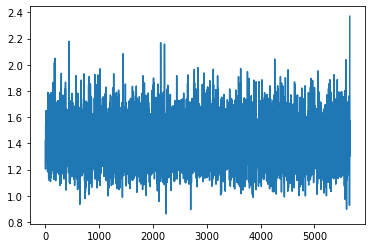

In [218]:
plt.plot(losses)

In [223]:
cd /content/Epilepsy-Detection


/content/Epilepsy-Detection


In [0]:
!git add .

In [228]:
!git commit -m “first commit”

error: pathspec 'commit”' did not match any file(s) known to git.
